
# Goal 

 Developing a forecasting model to predict the
number of antidiabetic drug prescriptions in
Australia

 Applying the modeling procedure with a SARIMA
model

 Evaluating our model against a baseline

 Determining the champion model

## Steps 

1 The objective is to forecast 12 months of antidiabetic drug prescriptions. Use
the last 36 months of the dataset as a test set to allow for rolling forecasts.

2 Visualize the time series.

3 Use time series decomposition to extract the trend and seasonal components.

4 Based on your exploration, determine the most suitable model.

5 Model the series with the usual steps:
    a Apply transformations to make it stationary
    
    b Set the values of d and D. Set the value of m.
    
    c Find the optimal (p,d,q)(P,D,Q)m parameters.
    
    d Perform residual analysis to validate your model.
    
6 Perform rolling forecasts of 12 months on the test set.

7 Visualize your forecasts.

8 Compare the model’s performance to a baseline. Select an appropriate baseline
and error metric.

9 Conclude whether the model should be used or not.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('../data/AusAntidiabeticDrug.csv')
print(df.shape)

C:\Users\sudha\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


(204, 2)


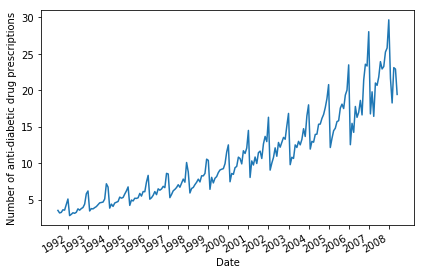

In [2]:
fig, ax = plt.subplots()
ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
fig.autofmt_xdate()
plt.tight_layout()

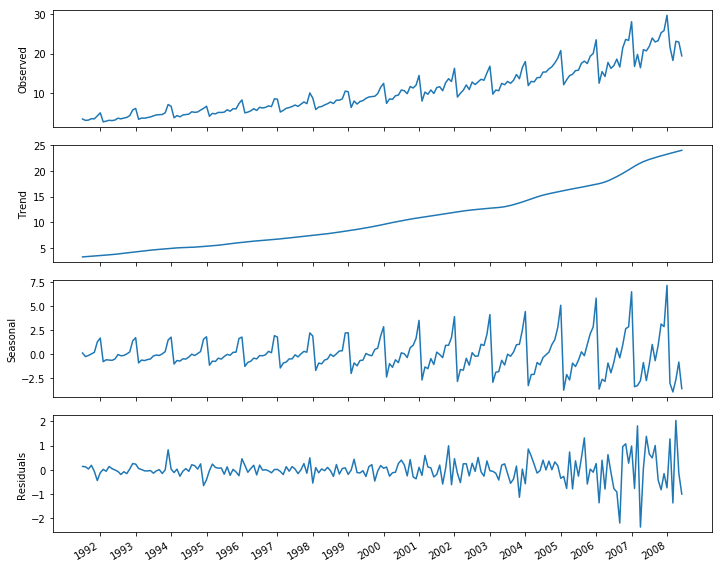

In [3]:
decomposition = STL(df.y, period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
fig.autofmt_xdate()
plt.tight_layout()

In [19]:
y_diff1= np.diff(df.y, n = 1 )
y_diff2= np.diff(y_diff1, n=1 )
y_diff3 = np.diff(y_diff1, n = 12)
Adf_score , pval = adfuller(y_diff3)[0],  adfuller(y_diff3)[1]
print(f'ADF Score : {Adf_score}')
print(f'Pval : {pval}')
print('The Series is stationary after differencing twice.')

ADF Score : -19.848440097997468
Pval : 0.0
The Series is stationary after differencing twice.


# Modelling

In [21]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series,list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
            endog,
            exog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [36]:
cut_off = y_diff2.shape[0]-36
train = df.y[:cut_off]
test = df.y[cut_off:]

In [37]:
p = range(4)
q = range(4)
P = range(4)
Q = range(4)
s = 12 
d = 2
D = 0 

order_list = list(product(p,q ,P, Q))

In [40]:
SARIMA_result_df = optimize_SARIMAX(train, None , order_list, d , D, s  )
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(0, 2, 3, 0)",323.583458
1,"(0, 2, 1, 1)",323.792557
2,"(0, 3, 1, 1)",324.477039
3,"(1, 2, 1, 1)",324.702329
4,"(0, 2, 2, 1)",324.763967
...,...,...
248,"(3, 0, 0, 0)",689.527858
249,"(0, 0, 0, 1)",692.402717
250,"(2, 0, 0, 0)",704.774200
251,"(1, 0, 0, 0)",739.259963


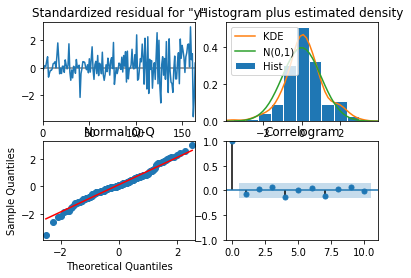

In [41]:
sarima_model = SARIMAX(
            train,
            order=(1,1,2),
            seasonal_order=(1,0, 1, 12),
            simple_differencing=False).fit(disp=False)
sarima_model.plot_diagnostics();

In [42]:
residuals = sarima_model.resid 
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.694665,0.404582
2,0.695638,0.706227
3,1.253567,0.740187
4,3.894981,0.420405
5,4.027324,0.545489
6,5.871683,0.437717
7,10.206908,0.177148
8,10.240687,0.248538
9,10.352612,0.322701
10,10.567129,0.392221


In [52]:
#Basline models 
# Rolling forecast
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,  window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'last_season':
        pred_last_season = []
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
        return pred_last_season
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(1,1,2), seasonal_order=(1,0,1,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA


In [53]:
cut_off = 168

In [54]:
 
pred_df = df[cut_off:]
train_len = 168
horizon = 36
window = 12 

pred_df['last_season'] = rolling_forecast(df, train_len, horizon,  window , method= 'last_season')
pred_df['SARIMA'] = rolling_forecast(df, train_len, horizon,  window , method= 'SARIMA')

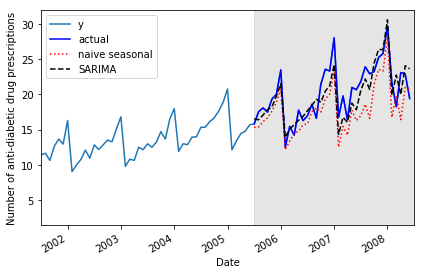

In [55]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

 

# Evaluation

In [56]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [57]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 8.48678065997391


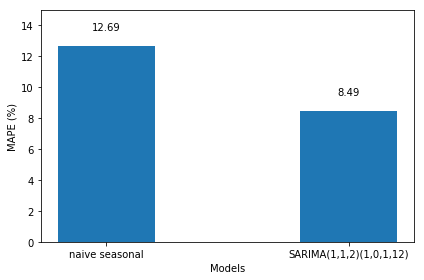

In [59]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(1,1,2)(1,0,1,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()
 